In [1]:
from IPython.display import clear_output

In [2]:
!pip install fastcluster yfinance
clear_output()

In [18]:
import os
import math

import matplotlib.pyplot as plt
import matplotlib.dates as md
import networkx as nx
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import yfinance as yf
from google.colab import output
from ipywidgets import Layout, widgets

%matplotlib inline

output.enable_custom_widget_manager()

# Data preprocessing

In [4]:
payload = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    )

In [5]:
# S&P500 metadata
sp500_table = payload[0]

In [6]:
sp500_table.head()

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981


In [7]:
# mappings 
sp500_tickers = sp500_table.Symbol.str.upper().values
sp500_names = sp500_table.Security.values
sp500_sectors = sp500_table['GICS Sector'].values
sp500_sub_sectors = sp500_table['GICS Sub-Industry'].values
sp500_names_mapping = dict(zip(sp500_tickers, sp500_names))
sp500_sector_mapping = dict(zip(sp500_names, sp500_sectors))
sp500_sub_sector_mapping = dict(zip(sp500_names, sp500_sub_sectors))

sector_color_mapping = dict(
    zip(
        sp500_sectors,
        sns.color_palette('bright', len(sp500_sectors)).as_hex()
        )
    )

subsector_color_mapping = dict(
    zip(
        sp500_sub_sectors,
        sns.color_palette('bright', len(sp500_sub_sectors)).as_hex()
        )
    )

In [8]:
# download S&P500 financial data
tickers = list(sp500_tickers)

prices = yf.download(
    tickers, start='2020-01-01', end='2021-12-31', interval='1d'
    )

prices = prices['Adj Close']
prices = prices.rename(columns=sp500_names_mapping)

[*********************100%***********************]  504 of 504 completed

3 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- CEG: Data doesn't exist for startDate = 1577836800, endDate = 1640908800
- BRK.B: No data found, symbol may be delisted


In [9]:
# impute
for i, row in prices.iterrows():
    if row.isnull().mean() > 0.9: prices.drop(i, inplace=True)

prices = prices.loc[:, prices.isnull().mean() < 0.3]
prices = prices.fillna(method='bfill')

In [10]:
print(prices.shape)

(504, 500)


In [11]:
prices.head()

,Agilent Technologies,American Airlines Group,Advance Auto Parts,Apple,AbbVie,AmerisourceBergen,Abiomed,Abbott,Accenture,Adobe,...,Wynn Resorts,Xcel Energy,ExxonMobil,Dentsply Sirona,Xylem,Yum! Brands,Zimmer Biomet,Zebra,Zions Bancorp,Zoetis
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,84.666740,28.982893,155.478271,73.785912,80.137360,81.815147,168.809998,83.667686,203.171112,334.429993,...,142.405029,58.709499,60.554623,55.849358,77.805450,97.649086,142.720764,259.140015,49.903751,132.200836
2020-01-03,83.307350,27.548195,155.488022,73.068573,79.376686,80.786201,166.820007,82.647697,202.832748,331.809998,...,140.292755,58.991844,60.067795,55.231319,78.263412,97.343231,142.347733,256.049988,49.199547,132.220535
2020-01-06,83.553627,27.219410,152.932632,73.650780,80.003105,81.969002,179.039993,83.080704,201.508240,333.709991,...,140.015091,58.907143,60.529007,55.535431,77.756737,97.285896,141.525070,258.010010,48.600010,131.205460
2020-01-07,83.809731,27.119778,151.118530,73.304413,79.546715,81.382401,180.350006,82.618835,197.157669,333.390015,...,140.679504,58.784786,60.033634,55.829739,77.464417,97.457916,141.400726,256.470001,48.305000,131.648926
2020-01-08,84.637177,27.737495,149.382446,74.483604,80.110481,82.170944,178.690002,82.955620,197.544403,337.869995,...,141.562103,58.728325,59.128296,56.418346,77.727501,97.629967,143.093842,247.639999,48.780827,131.363113


In [12]:
# calculate rolling correlation
corr = prices.rolling(60).corr()

corr_ = np.array(
    [corr.loc[i].to_numpy() for i in prices.index
     if not np.isnan(corr.loc[i].to_numpy()).all()]
    )

corr_ = np.nansum(corr_, axis=0) / len(corr_)

corr_ = pd.DataFrame(
    columns=prices.columns.tolist(), index=prices.columns.tolist(), data=corr_
    )

# Heatmap

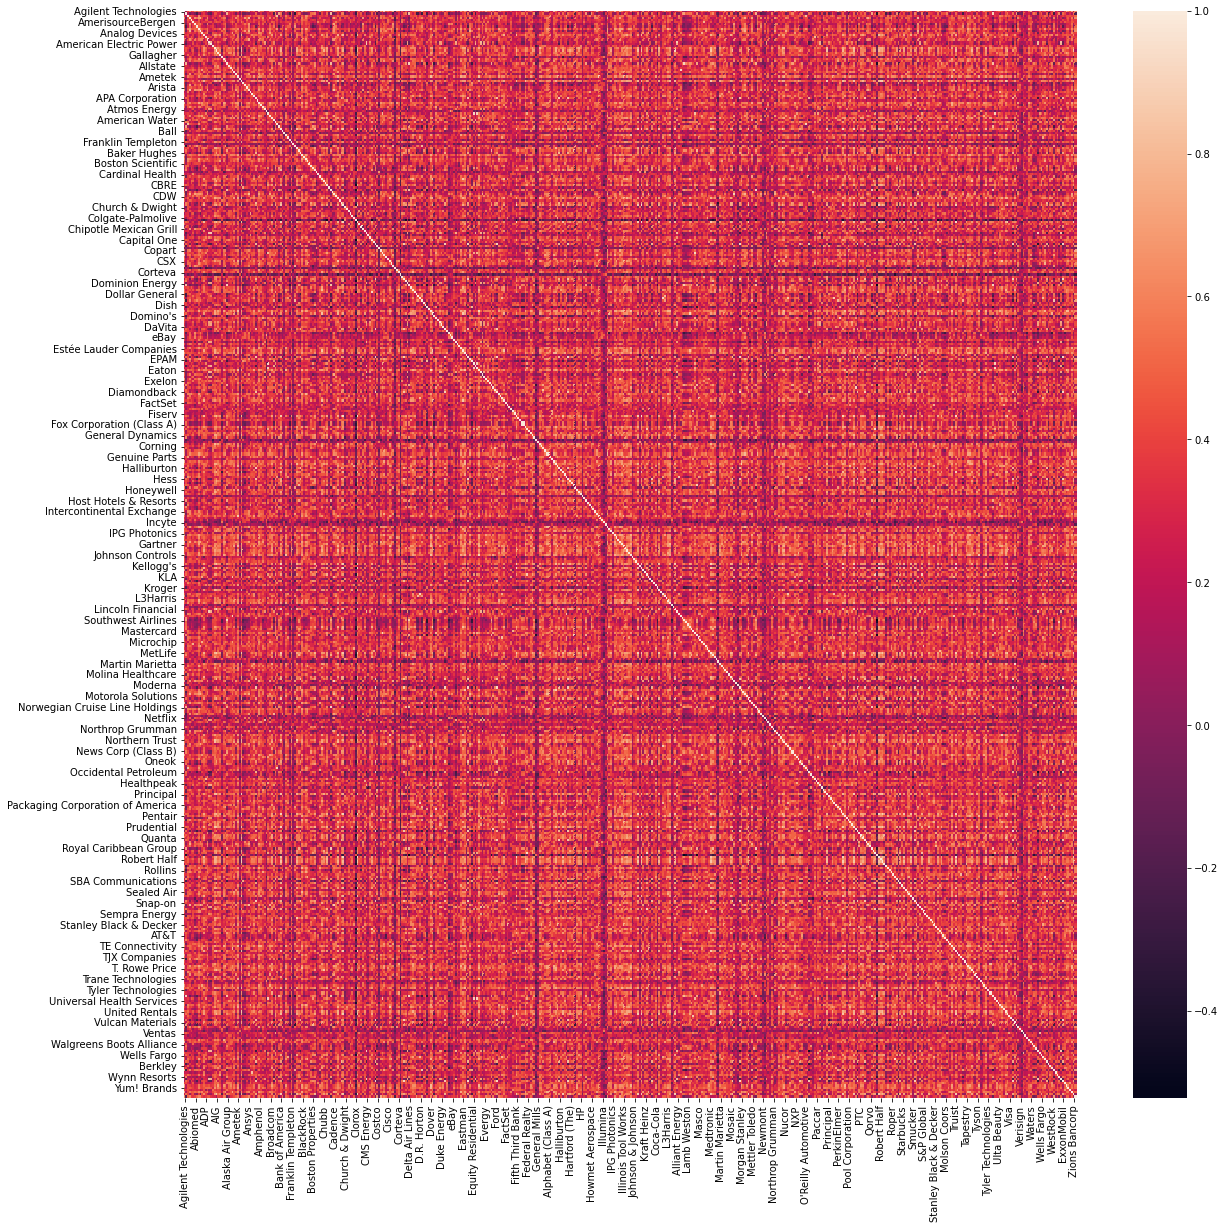

In [14]:
plt.figure(figsize=(20, 20))
sns.heatmap(corr_)

# Clustermap

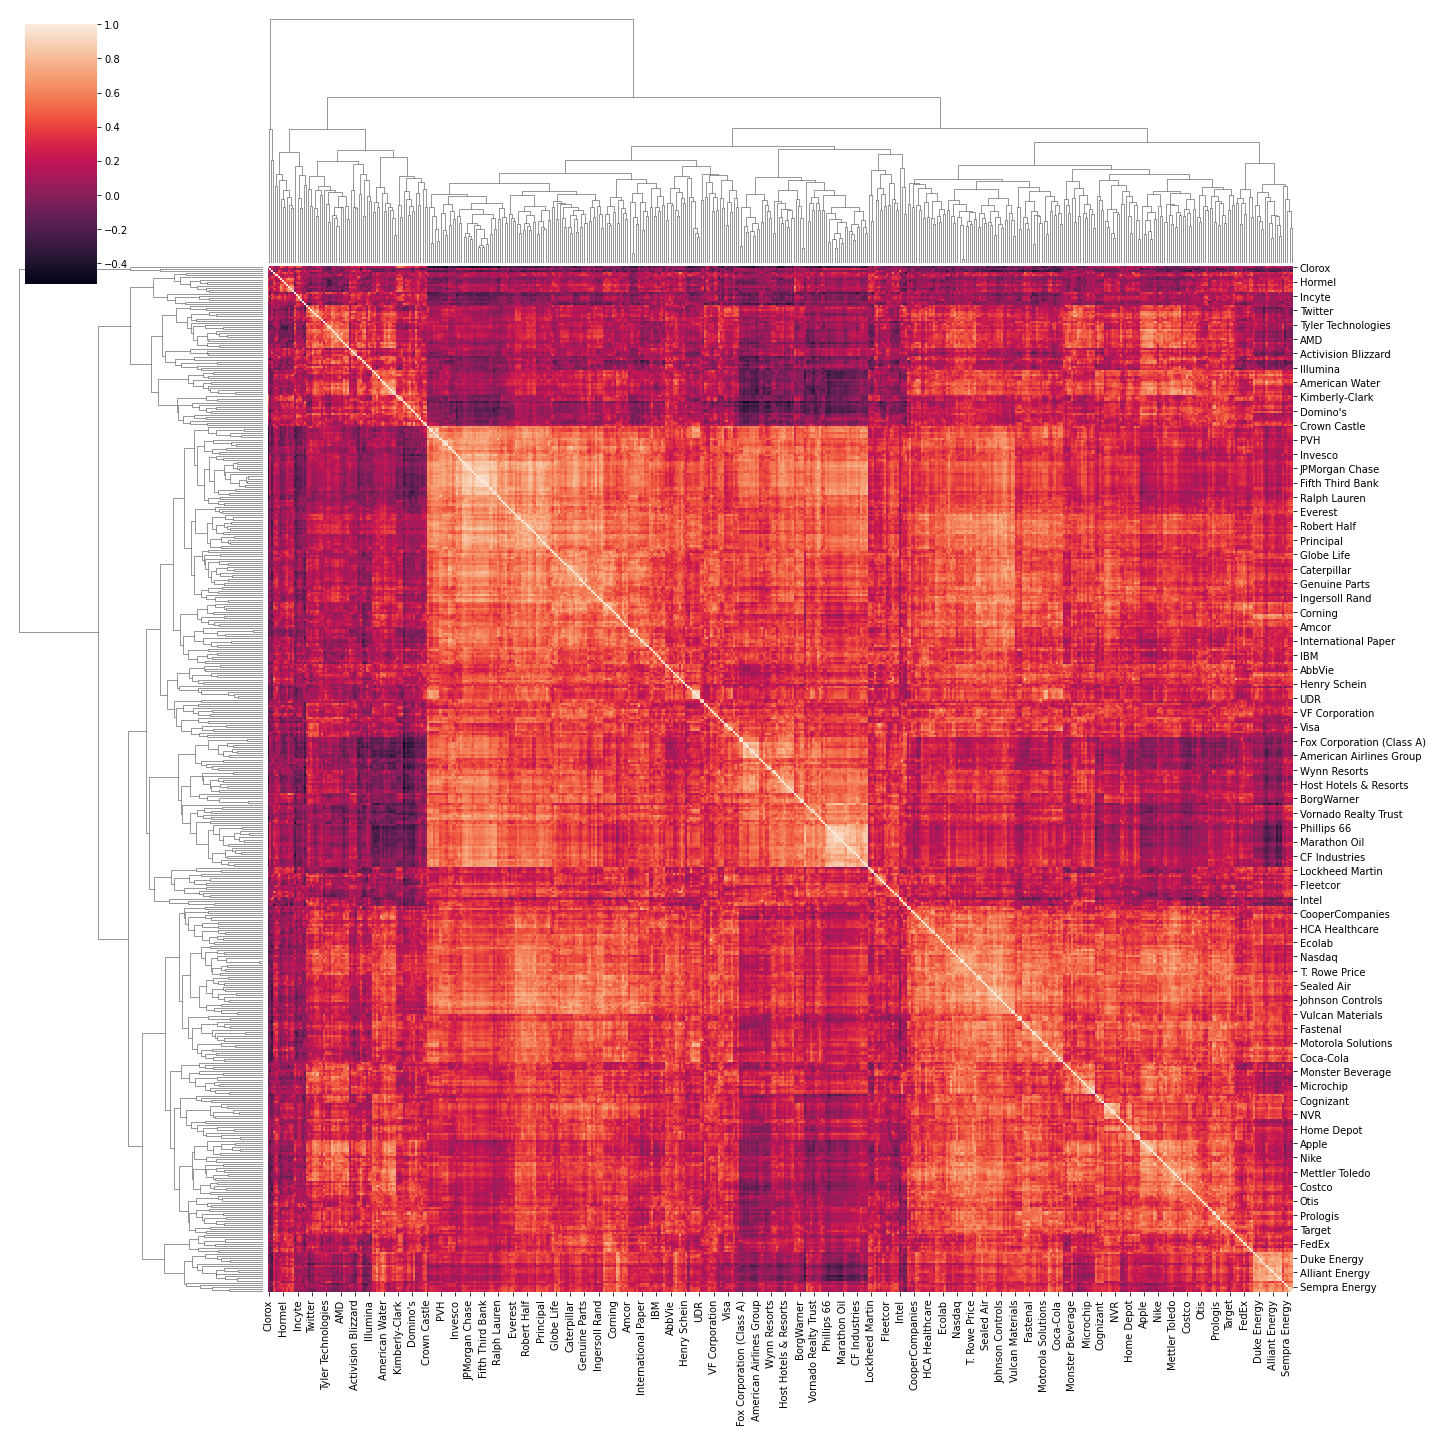

In [13]:
sns.clustermap(corr_, figsize=(20, 20))

# Network graph

In [15]:
threshold_choice = widgets.FloatSlider(
    description="Threshold", value=0.8, min=0.5, max=1, step=0.05,
    continuous_update=False, orientation='horizontal',
    layout=Layout(width='500px'), style=dict(description_width= 'initial')
    )

network = go.FigureWidget(
    data=[
          go.Scatter(
              x=[], y=[], mode='lines', text=[],
              line=dict(color='MediumPurple', width=10),
              marker=dict(
                  size=20, line_width=10,line=dict(color='MediumPurple',width=2)
                  )
              ),
          go.Scatter(
              x=[], y=[],mode='markers+text', textposition='top center',
              text=[],hoverinfo='text', textfont_size=12,
              marker=dict(size=50, color=[],line_width=1))
          ],
    layout=go.Layout(
        showlegend=False, annotations=[], margin=dict(t=40, b=0, l=0, r=0),
        width=1600, height=800
        )
    )

In [16]:
df = prices.copy()
correlation_matrix = corr_.to_numpy()

In [17]:
def assign_color(col):
    return sector_color_mapping[sp500_sector_mapping[col]]


def assign_color_edge(correlation):
    return '#BF0603' if correlation < 0 else '#00CC66'


def get_dim_of_node(name, tree):
    for node, (x, y) in tree:
        if node == name:
            return x, y

In [19]:
def plot_corr_graph(change):
    threshold, corr_mode = None, None
    threshold = change.new
    
    tr_ind = np.triu_indices(correlation_matrix.shape[0])
    correlation_matrix[tr_ind] = 0
    G = nx.from_numpy_matrix(correlation_matrix)
    G = nx.relabel_nodes(G, lambda x: df.columns.tolist()[x])
    remove = []
    
    for col1, col2, weight in G.edges(data=True):
      if math.isnan(weight['weight']):
        remove.append((col1, col2))
    
      if abs(weight['weight']) < threshold:
        remove.append((col1, col2))
    
    G.remove_edges_from(remove)
    
    remove = []
    edges = list(sum(G.edges, ()))
    
    for node in G.nodes:
      if node not in edges:
        remove.append(node)

    G.remove_nodes_from(remove)
    mst = nx.maximum_spanning_tree(G)

    edge_colors = []
    node_colors = []

    for key, value in nx.get_edge_attributes(mst, 'weight').items():
        edge_colors.append(assign_color_edge(value))

    for key, value in dict(mst.degree).items():
        node_colors.append(assign_color(key))
      
    labels = {n: n for n in mst.nodes()}
    node_x = []
    node_y = []
    
    tree = nx.fruchterman_reingold_layout(mst, k=0.25).items()

    for node, (x_, y_) in tree:
        node_x.append(x_)
        node_y.append(y_)
        
    edge_x = []
    edge_y = []
    
    weights= []

    for node1, node2, w in mst.edges(data=True):
        x0, y0 = get_dim_of_node(node1, tree)
        x1, y1 =  get_dim_of_node(node2, tree)
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)
        weights.append((round(w['weight'], 1), (x0 + x1) / 2, (y0 + y1) / 2))
                              
    with network.batch_update():
        network.data[1].x = node_x
        network.data[1].y = node_y
        network.data[1].text = list(labels)
        network.data[1].marker.color = node_colors
        network.data[0].x = edge_x
        network.data[0].y = edge_y
        network.data[0].text = list(weights)
        network.update_layout(
            xaxis_zeroline=False, yaxis_zeroline=False,
            xaxis_showgrid=False, yaxis_showgrid=False,
            plot_bgcolor='rgba(0,0,0,0)'
            )

In [21]:
threshold_choice.observe(plot_corr_graph, names='value')
widgets.VBox([threshold_choice, network])

In [22]:
network

FigureWidget({
    'data': [{'line': {'color': 'MediumPurple', 'width': 10},
              'marker': {'line': …